## Setup
* check the package version
* setup the font size of plot
* define the save_fig function


In [1]:
import sys 
from packaging import version
import sklearn
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
# This project requires Python 3.7 or above:
assert sys.version>='3.7'
assert sys.version_info >= (3,7)
#It also requires Scikit-Learn ≥ 1.0.1:
assert version.parse(sklearn.__version__) >=version.parse('1.0.1')

In [3]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [4]:
IMAGE_PATH = Path()/'images'/ 'ensembles'
IMAGE_PATH.mkdir(parents=True, exist_ok=True)

In [5]:
def save_fig(figure_id, extension='png', resolution=300, tight_layout=True ):
    image_detail= IMAGE_PATH/f"{figure_id}.{extension}"
    if tight_layout:
        plt.tight_layout()
    print(f'Saving {figure_id}...')
    plt.savefig(image_detail, dpi=resolution,format= extension)

## Voting classifier

In [37]:
import numpy as np

Saving law_of_large_numbers_plot...


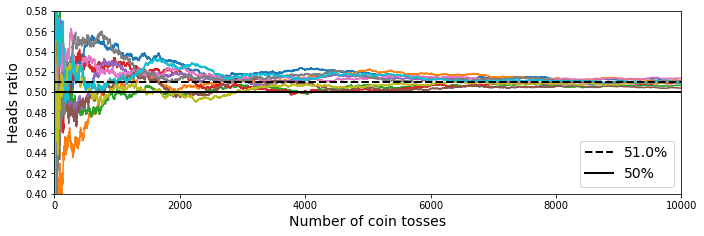

In [38]:
head_prob =0.51
np.random.seed(42)
coin_tosses = (np.random.rand(10000,10) <head_prob).astype(np.int32)
cumulative_heads = np.cumsum(coin_tosses, axis=0)
cumulative_heads_ratio = cumulative_heads/np.arange(1,10001).reshape(-1,1)

plt.figure(figsize=(10,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0,10000],[0.51, 0.51], 'k--',linewidth=2, label=f'{head_prob*100}%')
plt.plot([0,10000],[0.5, 0.5], 'k',linewidth=2, label='50%')
plt.axis([0,10000,0.4,0.58])
plt.legend(loc='lower right')
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")

save_fig("law_of_large_numbers_plot")
plt.show()

In [39]:
# Building a voting classifier
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

In [40]:
X_moons, y_moons= make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_moons, y_moons, random_state=42)
svm_clf = SVC(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
lr_clf = LogisticRegression(random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr_clf),
        ('svm', svm_clf),
        ('rf', rnd_clf)
    ],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('svm', SVC(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42))])

In [129]:

for clf in (lr_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__,accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.872
VotingClassifier 0.92


In [42]:
# soft voting
voting_clf.voting ='soft'
svm_clf.probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

## Bagging and pasting

In [43]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [44]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=100,
    n_jobs=-1,
    random_state=42

)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [45]:
def plot_decision_boundary(clf, X, y,axes=[-2,3,-1.5,2], show_ylabel=True, alpha=1.0):
    x1,x2 = np.meshgrid(np.linspace(axes[0], axes[1],num=100),
                     np.linspace(axes[2], axes[3], num=100))
    X_new = np.c_[x1.ravel(), x2.ravel()]

    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1,x2,y_pred, alpha=0.3*alpha, cmap='Wistia')
    plt.contour(x1,x2,y_pred,cmap="Greys", alpha=0.8 * alpha)
    
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx,(color, marker) in enumerate(zip(colors, markers)):   
        plt.plot(X[:,0][y==idx], X[:,1][y==idx],color=color, marker=marker, linestyle='none')
    plt.axis(axes)   
    plt.xlabel(r'$x_1$')
    if not show_ylabel:
        plt.ylabel('')
    else:
        plt.ylabel(r'$x_2$', rotation=0)

Saving decision_tree_without_and_with_bagging_plot...


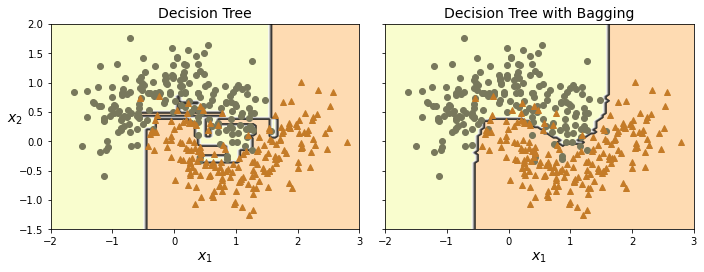

In [46]:
dt_clf= DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

_,axes = plt.subplots(ncols=2, sharey=True, figsize=(10,4))
plt.sca(axes[0])
plot_decision_boundary(dt_clf, X_train, y_train)
plt.title('Decision Tree')

plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train,show_ylabel=False)
plt.title('Decision Tree with Bagging')

save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

## Out of bag evaluation

In [47]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(),
                           n_estimators=500,
                           random_state=42,
                           n_jobs=1,
                           oob_score=True)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

In [48]:
bag_clf.oob_decision_function_[:3]

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

In [49]:
y_pred= bag_clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.92

If you randomly draw one instance from a dataset of size _m_, each instance in the dataset obviously has probability 1/_m_ of getting picked, and therefore it has a probability 1 – 1/_m_ of not getting picked. If you draw _m_ instances with replacement, all draws are independent and therefore each instance has a probability (1 – 1/_m_)<sup>_m_</sup> of not getting picked. Now let's use the fact that exp(_x_) is equal to the limit of (1 + _x_/_m_)<sup>_m_</sup> as _m_ approaches infinity. So if _m_ is large, the ratio of out-of-bag instances will be about exp(–1) ≈ 0.37. So roughly 63% (1 – 0.37) will be sampled.



In [50]:
np.exp(-1)

0.36787944117144233

In [51]:
(1-1/1000)**1000

0.36769542477096373

   ## Random Forest

In [52]:
rf_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, 
                               n_jobs=-1, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

In [53]:
# A random forest is equivalent to a bag of decision trees
bag_clf =BaggingClassifier(DecisionTreeClassifier(max_features='sqrt', max_leaf_nodes=16),
                          n_estimators=500, n_jobs=-1, random_state=42)

bag_clf.fit(X_train, y_train)
y_pred_bag= bag_clf.predict(X_test)
np.all(y_pred_rf==y_pred_bag)


True

### Feature importance

In [54]:
from sklearn.datasets import load_iris

In [55]:
iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)

RandomForestClassifier(n_estimators=500, random_state=42)

In [56]:
for name, score in zip(iris.data.columns,rnd_clf.feature_importances_):
    print(name, round(score,2))


sepal length (cm) 0.11
sepal width (cm) 0.02
petal length (cm) 0.44
petal width (cm) 0.42


In [57]:
from sklearn.datasets import fetch_openml

In [58]:
X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

RandomForestClassifier(random_state=42)

Saving mnist_feature_importance_plot...


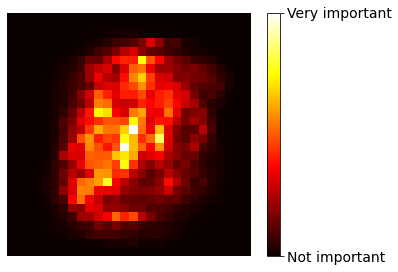

In [59]:
heatmap_image = rnd_clf.feature_importances_.reshape(28,28)
plt.imshow(heatmap_image, cmap='hot')
plt.axis('off')
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                          rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(["Not important", "Very important"],fontsize=14)

save_fig('mnist_feature_importance_plot')
plt.show()

## Boosting
### AdaBoost

Saving boosting_plot...


<function matplotlib.pyplot.show(close=None, block=None)>

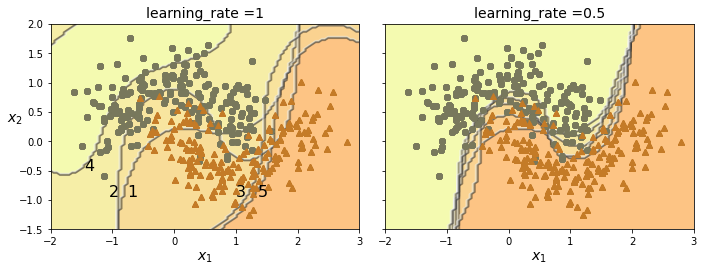

In [60]:
m = len(X_train)
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

for subplot, learning_rate in ((0,1),(1,0.5)):
    sample_weights = np.ones(m)/m
    plt.sca(axes[subplot])
    
    for i in range(5):
        svm_clf = SVC(C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight= sample_weights * m)
        y_pred_svm = svm_clf.predict(X_train)
        
        error_weights = sample_weights[y_train != y_pred_svm].sum()
        r= error_weights/sample_weights.sum()
        alpha =learning_rate* np.log((1-r)/r)
        sample_weights[y_pred_svm!=y_train] *= np.exp(alpha)
        
        sample_weights /=sample_weights.sum()
        plot_decision_boundary(svm_clf, X_train, y_train,alpha=0.4)
        plt.title( f"learning_rate ={learning_rate}")
        
    if subplot==0:
        plt.text(-0.75, -0.95, "1", fontsize=16)
        plt.text(-1.05, -0.95, "2", fontsize=16)
        plt.text(1.0, -0.95, "3", fontsize=16)
        plt.text(-1.45, -0.5, "4", fontsize=16)
        plt.text(1.36,  -0.95, "5", fontsize=16)
        
    else:
        plt.ylabel("")

save_fig("boosting_plot")        
plt.show
    

In [61]:
from sklearn.ensemble import AdaBoostClassifier

In [62]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators= 30,
    algorithm='SAMME.R', learning_rate=0.5, random_state=42
)
ada_clf.fit(X_train,y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

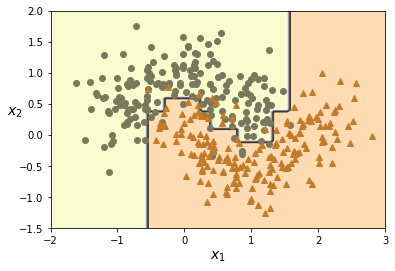

In [63]:
plot_decision_boundary(ada_clf, X_train, y_train)

### Gradient Boosting
Gradient Boosting tries to fit the new predictor to the *residual errors* made by previous predictor

In [65]:
from sklearn.tree import DecisionTreeRegressor

In [75]:
#Let's create y =3x² + Gaussian noise
np.random.seed(42)
X = np.random.rand(100,1) - 0.5
y = 3 * X[:, 0] **2 + 0.05*np.random.randn(100)

tree_reg1= DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X,y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [76]:
# imitating the whole process of Gradient Boosting
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

In [77]:
y3 =y2-tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

In [78]:
X_new = np.array([[-0.4], [0],[0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

In [73]:
tree_reg1

DecisionTreeRegressor(max_depth=2, random_state=42)

In [94]:
def plot_prediction(regressors, X,y, axes, style,label=None, data_style='b.',data_label=None):
    x1=np.linspace(axes[0], axes[1],500)
    y_pred= sum(model.predict(x1.reshape(-1,1)) for model in regressors)
    plt.plot(x1,y_pred,style,linewidth=2, label=label)
    plt.plot(X[:,0],y, data_style, label=data_label)
    if label or data_label:
        plt.legend(loc='upper center')
    plt.axis(axes)
    
    

Saving gradient_boosting_plot...


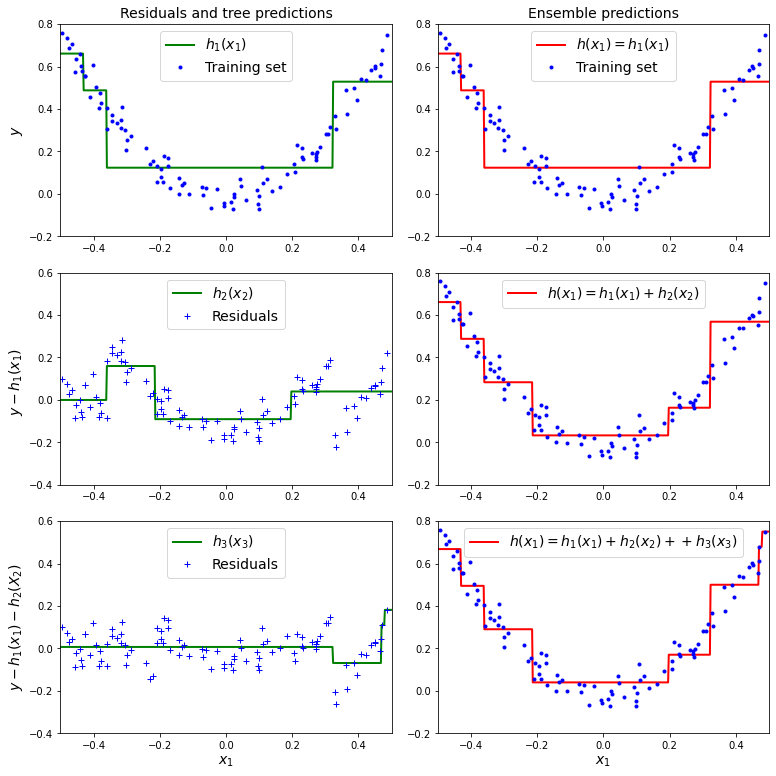

In [107]:
plt.figure(figsize=(11,11))

axes_1=[-0.5, 0.5, -0.2, 0.8]
axes_2 =[-0.5, 0.5, -0.4, 0.6]
plt.subplot(3,2,1)
plot_prediction([tree_reg1], X,y, axes=axes_1, style='g-',
               label='$h_1(x_1)$', data_label='Training set')
plt.ylabel("$y$", rotation=90)
plt.title("Residuals and tree predictions")

plt.subplot(3,2,2)
plot_prediction([tree_reg1], X,y, axes=axes_1, style='r-',
               label='$h(x_1)=h_1(x_1)$', data_label='Training set')
plt.title('Ensemble predictions')

plt.subplot(3,2,3)
plot_prediction([tree_reg2], X,y2, axes=axes_2, style='g-',
               label='$h_2(x_2)$',data_style='b+', data_label='Residuals',
               )
plt.ylabel("$y-h_1(x_1)$  ", rotation=90)


plt.subplot(3,2,4)
plot_prediction([tree_reg1, tree_reg2], X,y, axes=axes_1, style='r-',
               label='$h(x_1)=h_1(x_1)+h_2(x_2)$')

plt.subplot(3,2,5)
plot_prediction([tree_reg3], X,y3, axes=axes_2, style='g-',
               label='$h_3(x_3)$',data_style='b+', data_label='Residuals',
               )
plt.ylabel("$y-h_1(x_1)-h_2(X_2)$", rotation=90)
plt.xlabel('$x_1$')

plt.subplot(3,2,6)
plot_prediction([tree_reg1, tree_reg2, tree_reg3], X,y, axes=axes_1, style='r-',
               label='$h(x_1)=h_1(x_1)+h_2(x_2)++h_3(x_3)$')
plt.xlabel('$x_1$')


save_fig("gradient_boosting_plot")
plt.show()

In [108]:
# gradient boosting regressor
from sklearn.ensemble import GradientBoostingRegressor

In [109]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [112]:
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=500, learning_rate=0.05,
                                     n_iter_no_change=10,random_state=42)
gbrt_best.fit(X,y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

In [114]:
gbrt_best.n_estimators_

92

Saving gbrt_learning_rate_plot...


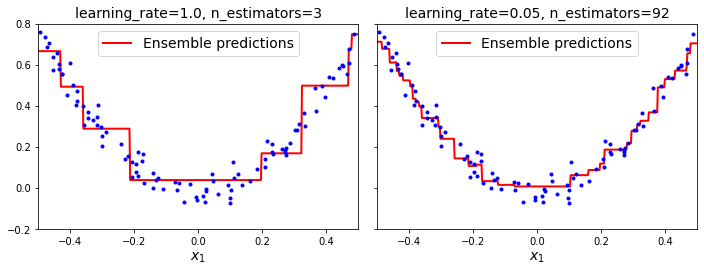

In [124]:
_, axes= plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_prediction([gbrt], X,y, axes=axes_1, style='r-',label="Ensemble predictions")
plt.xlabel('$x_1$',rotation=0)
plt.title(f"learning_rate={gbrt.learning_rate}, n_estimators={gbrt.n_estimators_}")


plt.sca(axes[1])
plot_prediction([gbrt_best], X,y, axes=axes_1, style='r-',label="Ensemble predictions")
plt.xlabel('$x_1$')
plt.title(f"learning_rate={gbrt_best.learning_rate}, n_estimators={gbrt_best.n_estimators_}")


save_fig("gbrt_learning_rate_plot")
plt.show()

## Stacking

In [125]:
from sklearn.ensemble import StackingClassifier

In [138]:
stacking_clf= StackingClassifier(
    estimators=[

        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),        
        ('svc', SVC(probability=True, random_state=42)),        



    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=5 #number of cross-validation folds

)

In [139]:
# Different sequences of predictor have different scores
stacking_clf.fit(X_train,y_train)
stacking_clf.score(X_test,y_test)

0.928

## Ensemble practice in MNIST data set

In [7]:
# Load the MNIST data and split it into a training set, a validation set and a test set(50,000, 10,000 and 10,000)
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier

In [8]:
mnist = fetch_openml('mnist_784', version=1)
X,y=mnist.data, mnist.target

In [18]:
X_train, X_valid, X_test = X[:50_000],X[50_000:60_000],X[60_000:]
y_train, y_valid, y_test = y[:50_000],y[50_000:60_000],y[60_000:]

In [151]:
#Train various classifiers, such as Random Forest classifier, Extra-Tree classifer and svm classifier
rnd_clf = RandomForestClassifier(random_state=42,n_jobs=-1)
svm_clf = SVC(random_state=42,probability=True)
extra_clf =ExtraTreesClassifier(random_state=42, n_jobs=-1)

In [152]:
rnd_clf.fit(X_train, y_train)
svm_clf.fit(X_train, y_train)
extra_clf.fit(X_train, y_train)

ExtraTreesClassifier(n_jobs=-1, random_state=42)

In [153]:
vot_clf= VotingClassifier(
    estimators=[('rf', rnd_clf),
               ('svm',svm_clf),
               ('extra', extra_clf)],
    voting ='hard'
    
)
vot_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(n_jobs=-1,
                                                     random_state=42)),
                             ('svm', SVC(probability=True, random_state=42)),
                             ('extra',
                              ExtraTreesClassifier(n_jobs=-1,
                                                   random_state=42))])

In [156]:
vot_clf_soft= VotingClassifier(
    estimators=[('rf', rnd_clf),
               ('svm',svm_clf),
               ('extra', extra_clf)],
    voting ='soft'
    
)
vot_clf_soft.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(n_jobs=-1,
                                                     random_state=42)),
                             ('svm', SVC(probability=True, random_state=42)),
                             ('extra',
                              ExtraTreesClassifier(n_jobs=-1,
                                                   random_state=42))],
                 voting='soft')

In [158]:
for clf in (rnd_clf, svm_clf, extra_clf, vot_clf, vot_clf_soft):
    y_pred_valid=clf.predict(X_valid)
    print(clf.__class__.__name__, accuracy_score(y_valid, y_pred_valid))

RandomForestClassifier 0.9736
SVC 0.9802
ExtraTreesClassifier 0.9743
VotingClassifier 0.9778
VotingClassifier 0.9813


In [162]:
print(vot_clf.score(X_test, y_test))

0.9737


In [161]:
[estimator.score(X_test, y_test.astype(np.int32)) for estimator in vot_clf.estimators_]

[0.968, 0.9785, 0.9703]

In [163]:
vot_clf_soft.score(X_test, y_test)

0.9783

* Method 2: change svm to LinearSVC to improve the speed and add MLPClassifier(Multi layer perceptron classifier

In [22]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

In [16]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(max_iter=100, tol=20, random_state=42)
lr_clf = LogisticRegression(n_jobs=-1, random_state=42, max_iter=100)
mlp_clf = MLPClassifier(random_state=42)
extra_clf = ExtraTreesClassifier(n_estimators=100, n_jobs=-1, random_state=42)

In [19]:
estimators=[rnd_clf, svm_clf, lr_clf, mlp_clf, extra_clf]
for estimator in estimators:
    print('Training ', estimator)
    estimator.fit(X_train, y_train)

Training  RandomForestClassifier(random_state=42)
Training  LinearSVC(max_iter=100, random_state=42, tol=20)
Training  LogisticRegression(n_jobs=-1, random_state=42)
Training  MLPClassifier(random_state=42)
Training  ExtraTreesClassifier(n_jobs=-1, random_state=42)


In [20]:
[estimator.score(X_valid,y_valid) for estimator in estimators]

[0.9736, 0.8662, 0.9272, 0.9631, 0.9743]

In [23]:
named_estimators =[
    ('rf', rnd_clf),
    ('svm',svm_clf),    
    ('lr', lr_clf),
    ('mlp', mlp_clf),
    ('extra', extra_clf)
]

voting_clf = VotingClassifier(named_estimators) # default setting is hard vote
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('svm',
                              LinearSVC(max_iter=100, random_state=42, tol=20)),
                             ('lr',
                              LogisticRegression(n_jobs=-1, random_state=42)),
                             ('mlp', MLPClassifier(random_state=42)),
                             ('extra',
                              ExtraTreesClassifier(n_jobs=-1,
                                                   random_state=42))])

In [24]:
voting_clf.score(X_valid, y_valid)

0.9719

In [25]:
voting_clf

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('svm',
                              LinearSVC(max_iter=100, random_state=42, tol=20)),
                             ('lr',
                              LogisticRegression(n_jobs=-1, random_state=42)),
                             ('mlp', MLPClassifier(random_state=42)),
                             ('extra',
                              ExtraTreesClassifier(n_jobs=-1,
                                                   random_state=42))])

In [26]:
[estimator.score(X_valid, y_valid.astype(np.int32)) 
 for estimator in voting_clf.estimators_]

[0.9736, 0.8662, 0.9272, 0.9631, 0.9743]

In [27]:
# Let's remove the SVM to see if performance improves.
voting_clf.set_params(svm='drop')
voting_clf.estimators_

[RandomForestClassifier(random_state=42),
 LinearSVC(max_iter=100, random_state=42, tol=20),
 LogisticRegression(n_jobs=-1, random_state=42),
 MLPClassifier(random_state=42),
 ExtraTreesClassifier(n_jobs=-1, random_state=42)]

so we can either fit the `VotingClassifier` again, or just remove the `SVM` from the list or trained estimators both in `estimators_` and `named_estimators_`

In [28]:

svm_trained=voting_clf.named_estimators_.pop('svm')
voting_clf.estimators_.remove(svm_trained)

In [29]:
voting_clf.score(X_valid, y_valid)

0.9744

In [30]:
voting_clf.voting='soft'
voting_clf.score(X_valid, y_valid)

0.9716

In [31]:
voting_clf.voting='hard'
voting_clf.score(X_test, y_test)

0.9705

In [32]:
[estimator.score(X_test, y_test.astype(np.int32)) 
 for estimator in voting_clf.estimators_]

[0.968, 0.9243, 0.9628, 0.9703]

In [33]:
# remove Logistic regression
svm_trained = voting_clf.named_estimators_.pop('lr')
voting_clf.estimators_.remove(svm_trained)
voting_clf.estimators_

[RandomForestClassifier(random_state=42),
 MLPClassifier(random_state=42),
 ExtraTreesClassifier(n_jobs=-1, random_state=42)]

In [34]:
voting_clf.score(X_valid, y_valid)

0.9757

In [35]:
print(voting_clf.score(X_test, y_test))
[estimator.score(X_test, y_test.astype(np.int32)) 
 for estimator in voting_clf.estimators_]

0.9729


[0.968, 0.9628, 0.9703]

In [36]:
estimators=[rnd_clf,  mlp_clf, extra_clf]

### stacking ensemble
Run the individual classifiers from the previous exercise to make predictions on the validation set, and creating a new training set with the resulting predictions: each training instance is a vector containing the set of predictions from all your classifiers to an image, and the target is the image's class, Train a classifier on this new training set

In [37]:
X_valid_predictions = np.empty((len(X_valid),len(estimators)), dtype=object)

for idx, estimator in enumerate(estimators):
    X_valid_predictions[:, idx]= estimator.predict(X_valid)

In [39]:
X_valid_predictions

array([['3', '3', '3'],
       ['8', '8', '8'],
       ['6', '6', '6'],
       ...,
       ['5', '5', '5'],
       ['6', '6', '6'],
       ['8', '8', '8']], dtype=object)

In [41]:
rnd_forest_clf_blender = RandomForestClassifier(n_estimators=200, oob_score =True,
                                               random_state=42)
rnd_forest_clf_blender.fit(X_valid_predictions,y_valid)
rnd_forest_clf_blender.oob_score_

0.9741

In [56]:
# let's evaluate the ensemble on the test set. For each image in the test set. 
# make predictions with your classifiers, then feed the predictions to the blender to get the ensemble predictions
X_test_predictions = np.empty([len(X_test), len(estimators)],dtype='object')
for idx, estimator in enumerate(estimators):
    X_test_predictions[:,idx] = estimator.predict(X_test)
 

In [57]:
from sklearn.metrics import accuracy_score

In [59]:

y_pred = rnd_forest_clf_blender.predict(X_test_predictions)
accuracy_score(y_test, y_pred)

0.9698

This stacking ensemble(blender) does not perform as well as the voting classifier we trained earlier

In [60]:
# Now lets try using a `StackingClassifier` instead to see whether get a better performance

In [61]:
from sklearn.ensemble import StackingClassifier

In [65]:
# since StackingClassifier users K-Fold cross-validation, we don't need a seperate validation set
X_train_full, y_train_full = X[:50_000], y[:50_000]

In [66]:
#By default, it will beK-Fold validation with 5 folds
stack_clf = StackingClassifier(estimators=named_estimators,
                  final_estimator= rnd_forest_clf_blender)
stack_clf.fit(X_train_full, y_train_full)

StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('svm',
                                LinearSVC(max_iter=100, random_state=42,
                                          tol=20)),
                               ('lr',
                                LogisticRegression(n_jobs=-1, random_state=42)),
                               ('mlp', MLPClassifier(random_state=42)),
                               ('extra',
                                ExtraTreesClassifier(n_jobs=-1,
                                                     random_state=42))],
                   final_estimator=RandomForestClassifier(n_estimators=200,
                                                          oob_score=True,
                                                          random_state=42))

In [67]:
#Methods called for each base estimator. It can be:
# if ‘auto’, it will try to invoke, for each estimator, 'predict_proba', 'decision_function' or 'predict' in that order.

stack_clf.score(X_test, y_test)


0.9773